It was only possible to achieve an accuracy of 0.33; further manipulation with hyperparameters does not lead to anything in particular. Maybe resnet50 model will be much better, it should be tested

In [9]:
from tqdm import tqdm
total = 3000000
count=0
for i in tqdm(range(total)):
    # print(f'{i}번째 입니다!')
    count+=1

100%|██████████| 3000000/3000000 [00:01<00:00, 2186252.73it/s]


## Imports

In [1]:
import numpy as np
import pandas as pd

import os
import shutil
import torch
import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm

from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Subset

from IPython.display import clear_output

import matplotlib.pyplot as plt

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Othe

In [2]:
#!g1.1
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Load data

In [3]:
data = pd.read_csv('../Data/Youtube_thumbnails/metadata.csv')

## Prepare data

In [7]:
# !cp -r /kaggle/input/youtube-thumbnail-dataset/thumbnails/images/ ./

In [44]:
# data[['Category']].value.tolist()

image2text  = {}
image2category = {}
image2channel = {}
for i in data[['Id','Channel', 'Category','Title']].values.tolist():
    # print(i)
    image2text[i[0]] = i[3]
    image2category[i[0]] = i[2]
    image2channel[i[0]] = i[1]


In [52]:
ch2cat = {}
cur_ch = ""
for i in data[['Channel', 'Category']].values.tolist():
    if i[0] == cur_ch: continue
    cur_ch = i[0]
    ch2cat[cur_ch] = i[1]

categories = set(val for val in ch2cat.values())
channels = set(val for val in ch2cat.keys())

In [5]:
s = ""
for i in ch2cat.keys():
    if i == "Bon Appétit":
        s = i
        break
ch2cat["Bon Appetit"] = ch2cat[s]

In [6]:
# basedir = "/kaggle/working/images/"

# 카테고리별로 폴더 만듬.
basedir = "/Users/juniverse/Desktop/pointcloud/VectorUniverse/Data/Youtube_thumbnails/images"
for fn in os.listdir(basedir):
    if fn not in ch2cat.keys(): continue
    try:
        os.rename(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))
    except OSError:
        shutil.move(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))

In [7]:
batch_size = 64

In [8]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# based on https://gist.github.com/srikarplus/8bdb5bedf0ca25e894e39ea78fce2f39
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                      normalize])

    train_transform = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                      normalize])

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir, transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )


    return (train_loader, valid_loader, train_dataset.class_to_idx)

In [9]:
train_loader, test_loader, class_idx = get_train_valid_loader(basedir, batch_size, False, 42, 0.1)

In [63]:
for x in train_loader:
    print(type(x))
    print(len(x))
    print(x[0],x[1])
    break

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

<class 'list'>
2
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 1.9407,  1.9407,  1.9407,  ...,  1.9407,  1.9407,  1.9407],
          [ 1.9407,  1.9407,  1.9407,  ...,  1.9407,  1.9407,  1.9407],
          [ 1.9407,  1.9407,  1.9407,  ...,  1.9407,  1.9407,  1.9407]],

         [[ 0.8179,  0.8179,  0.8179,  ...,  0.8179,  0.8179,  0.8179],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.8179,  0.8179,  0.8179],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.8179,  0.8179,  0.8179],
          ...,
          [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
          [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630],
          [-1.5630, -1.5630, -1.5630,  ..., -1.5630, -1.5630, -1.5630]],

         [[ 2.2391,  2.2391,  2.2391,  ...,  2.2391,  2.2391,  2.2391],
          [ 2

In [10]:
class_idx

{'Automobile': 0,
 'Automobile,Comedy': 1,
 'Blog': 2,
 'Blog,Comedy': 3,
 'Blog,Entertainment': 4,
 'Blog,Science': 5,
 'Bon Appétit': 6,
 'Comedy': 7,
 'Comedy,Entertainment': 8,
 'Comedy,Informative': 9,
 'Entertainment': 10,
 'Entertainment,Blog': 11,
 'Entertainment,Comedy': 12,
 'Food': 13,
 'Food,Entertainment': 14,
 'Informative': 15,
 'News': 16,
 'Science': 17,
 'Tech': 18,
 'Tech,Comedy': 19,
 'Tech,Informative': 20,
 'Tech,News': 21,
 'VideoGames': 22}

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

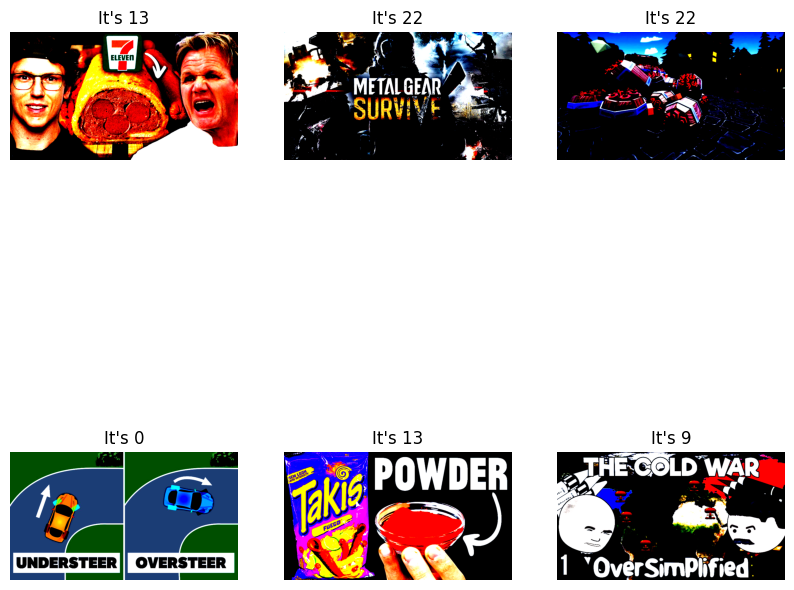

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for image, number in train_loader:
    for i in range(2):
        for j in range(3):
            ax[i, j].imshow(image[i * 3 + j].permute(1, 2, 0))
            ax[i, j].set_title(f'It\'s {number[i * 3 + j]}')
            ax[i, j].axis('off')
    break
fig.show()

## Prepare model

In [12]:
class Model(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(3, 16, 5, 3, 2), #in_channels, out_channels, kernel_size, stride=1, padding=0, 
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512*3*7, 256*3*7),
            nn.ReLU(),
            nn.Linear(256*3*7, 128*3*7),
            nn.ReLU(),
            nn.Linear(128*3*7, out_features)
        )
    
    def forward(self, x):
        return self.blocks(x)

In [13]:
#!g1.1
model = Model(len(categories))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 100

In [14]:
#!g1.1
model.to(device)

Model(
  (blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10752, out_features=5376, bias=True)
    (14): ReLU()
    (15): Linear(in_features=5376, out_features=2688, bias=True)
    (16): ReLU()
    (17): Linear(in_features=2688, out_features=22, bias=True)
  )
)

## Train

In [15]:
from IPython.display import clear_output

def plot_loss_accuracy(train_losses, train_accs, test_accs, n):
    clear_output()
    fig, ax = plt.subplots(1, 2, figsize=(26,10))
    ax[0].set_title(f'Train Loss, epoch {n}')
    ax[0].plot(train_losses)
    ax[1].set_title('Accuracy')
    ax[1].plot(train_accs, label='Train')
    ax[1].plot(test_accs, label='Test')
    ax[1].legend()
    plt.grid()
    plt.show()

In [16]:
#!g1.1
def train_epoch(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    train_losses = []
    train_accuracy = []

    for batch_X, batch_Y in tqdm(train_loader):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        optimizer.zero_grad()

        softmax = nn.Softmax()
        probs = softmax(model(batch_X))
        classes = torch.argmax(probs, dim=-1)
        loss = criterion(probs, batch_Y)

        loss.backward()

        train_losses.append(loss.item())
        train_accuracy.append((classes == batch_Y).float().mean().item())
        optimizer.step()
    
    return np.mean(train_losses), np.mean(train_accuracy)


def predict(model, test_loader, criterion, device='cpu'):
    model.eval()
    test_accuracy = []
    with torch.no_grad():
        for batch_X, batch_Y in tqdm(test_loader):
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            softmax = nn.Softmax()
            probs = softmax(model(batch_X))
            classes = torch.argmax(probs, dim=-1)
            
            test_accuracy.append((classes == batch_Y).float().mean().item())
    return np.mean(test_accuracy)


def train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device='cpu'):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        loss, accs = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(loss)
        train_accs.append(accs)
        test_accs.append(predict(model, test_loader, criterion, device))
        plot_loss_accuracy(train_losses, train_accs, test_accs, epoch)


In [67]:
#!g1.1
import warnings
warnings.filterwarnings("ignore")
train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
#!g1.1
predict(model, test_loader, criterion, device)

  0%|          | 0/4 [00:00<?, ?it/s]

0.34724506735801697